In [1]:
from environment import EnvironmentGoogleSnake
from torch import nn
import torch

from torchvision.transforms import ToTensor

import gymnasium as gym
import numpy as np

import matplotlib.pyplot as plt
import copy


from torchinfo import summary

In [2]:
class PreProcessEnv(gym.Wrapper):

    def __init__(self, env):
        gym.Wrapper.__init__(self, env=env)

    def reset(self):
        obs = self.env.reset()
        return ToTensor()(obs).unsqueeze(dim = 0).float()
    
    def step(self, action: torch.Tensor):
        action = action.item()
        next_state, reward, done, info = self.env.step(action)
        next_state = ToTensor()(next_state).unsqueeze(dim = 0)
        reward = torch.tensor(reward).view(1, -1).float()
        done = torch.tensor(done).view(1, -1)
        return next_state, reward, done, info
    

In [3]:
env = EnvironmentGoogleSnake()
env = PreProcessEnv(env)

env.unwrapped.start()
state = env.reset()


(-0.5, 127.5, 127.5, -0.5)

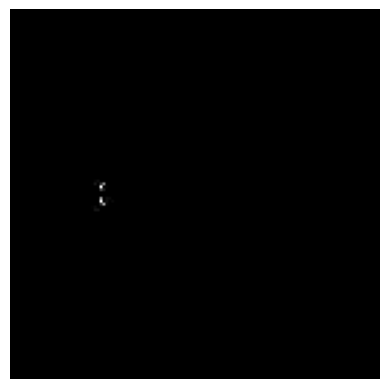

In [4]:

next_state, reward, done, info = env.step(torch.tensor(2))

plt.imshow(next_state.squeeze(), cmap="gray")
plt.axis("off")

In [5]:
class DeepRLModel(torch.nn.Module):

    def __init__(self, in_channels, hidden_units, out_channels):
        super().__init__()
        self.conv_block_1 = torch.nn.Sequential(
        torch.nn.Conv2d(in_channels = in_channels, out_channels = hidden_units, kernel_size = 3, padding = 1),
        torch.nn.ReLU(),
        torch.nn.Conv2d(in_channels=hidden_units, out_channels = hidden_units, kernel_size = 3, padding = 1),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size = 2, stride = 2)
        )

        self.conv_block_2 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels = hidden_units, out_channels = hidden_units, kernel_size =3, padding = 1 ),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels = hidden_units, out_channels = hidden_units, kernel_size = 3, padding = 1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2)
        )

        self.classifier = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(in_features = 20480, out_features = out_channels),
            torch.nn.Softmax(dim = 1)
        )

    def forward(self, x: torch.Tensor):
        return self.classifier(self.conv_block_2(self.conv_block_1(x)))

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
q_network = DeepRLModel(1, 20, 4).to(device)
summary(q_network, (3, 1,  128, 128))


Layer (type:depth-idx)                   Output Shape              Param #
DeepRLModel                              [3, 4]                    --
├─Sequential: 1-1                        [3, 20, 64, 64]           --
│    └─Conv2d: 2-1                       [3, 20, 128, 128]         200
│    └─ReLU: 2-2                         [3, 20, 128, 128]         --
│    └─Conv2d: 2-3                       [3, 20, 128, 128]         3,620
│    └─ReLU: 2-4                         [3, 20, 128, 128]         --
│    └─MaxPool2d: 2-5                    [3, 20, 64, 64]           --
├─Sequential: 1-2                        [3, 20, 32, 32]           --
│    └─Conv2d: 2-6                       [3, 20, 64, 64]           3,620
│    └─ReLU: 2-7                         [3, 20, 64, 64]           --
│    └─Conv2d: 2-8                       [3, 20, 64, 64]           3,620
│    └─ReLU: 2-9                         [3, 20, 64, 64]           --
│    └─MaxPool2d: 2-10                   [3, 20, 32, 32]           --
├─Seq

In [7]:
target_q_network = copy.deepcopy(q_network).to(device).eval()


In [8]:
q_network(next_state.to(device)).gather(1, torch.tensor([[1]]).to(device))

tensor([[0.2437]], device='cuda:0', grad_fn=<GatherBackward0>)

In [9]:
def policy(state, epsilon = 0.05):
    if torch.rand(1) < epsilon:
        return torch.randint(4, (1, 1))
    else:
        av = q_network(state.to(device))
        return torch.argmax(av, dim = -1, keepdim = True)

In [10]:
from torch.optim import AdamW
from memory import ReplayMemory
from tqdm import tqdm
import torch.nn.functional as F

def dqn_training(
    q_network: DeepRLModel,
    policy,
    episodes,
    alpha=0.0001,
    batch_size=32,
    gamma=0.99,
    epsilon=0.05,
):
    optim = torch.optim.AdamW(q_network.parameters(), lr=alpha)
    memory = ReplayMemory(capacity=10000)
    stats = {'MSE Loss': [], 'Returns': []}
    
    for episode in tqdm(range(1, episodes + 1)):
        state = env.reset()
        done = False
        ep_return = 0
        while not done:
            action = policy(state, epsilon)
            next_state, reward, done, _ = env.step(action)

            done = done.to(device)
            next_state = next_state.to(device)
            state = state.to(device)
            action = action.to(device)
            reward = reward.to(device)
            
            memory.insert([state, action, reward, done, next_state])
            
            if memory.can_sample(batch_size):
                state_b, action_b, reward_b, done_b, next_state_b = memory.sample(batch_size)   

                reward_b = reward_b.to(device)
                done_b = done_b.to(device)
                state_b = state_b.to(device)
                action_b = action_b.to(device)


                qsa_b = q_network(state_b).gather(1, action_b)
                
                next_qsa_b = target_q_network(next_state_b.to(device))
                next_qsa_b = torch.max(next_qsa_b, dim=-1, keepdim=True)[0].to(device)
                
                target_b = reward_b + ~(done) * gamma * next_qsa_b
                loss = F.mse_loss(qsa_b, target_b.to(device))
                q_network.zero_grad()
                loss.backward()
                optim.step()
                
                stats['MSE Loss'].append(loss)  
                
            state = next_state
            ep_return += reward.item()
            
        
        stats['Returns'].append(ep_return)
        
        if episode % 10 == 0:
            target_q_network.load_state_dict(q_network.state_dict())

    return stats

In [11]:
dqn_training(q_network, policy, episodes = 1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

  5%|▌         | 54/1000 [03:09<53:34,  3.40s/it]  